# RECEPTOR
- Codigo Fuente de Receptor.ipynb
- Autor:  Uberti, Ulises Leandro
- Asignatura: Señales Electricas
- Año: 2025

# Librerias y funciones necesarias

In [1]:
#Importamos las librerias necesarias 
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import wave

#Subimos de nivel la carpeta para importar las funciones de otros archivos 
import sys 
sys.path.append("..")

#Importamos las funciones de otros archivos 
from modules.caracteristicas import Audio_Caracteristicas,Audio_FFT,Audio_Grafica
from scipy.signal import resample_poly
from scipy.io import wavfile
from modules.codificar import Codificar_Senial
from scipy.signal import butter, filtfilt


# Archivo con señal moduladala

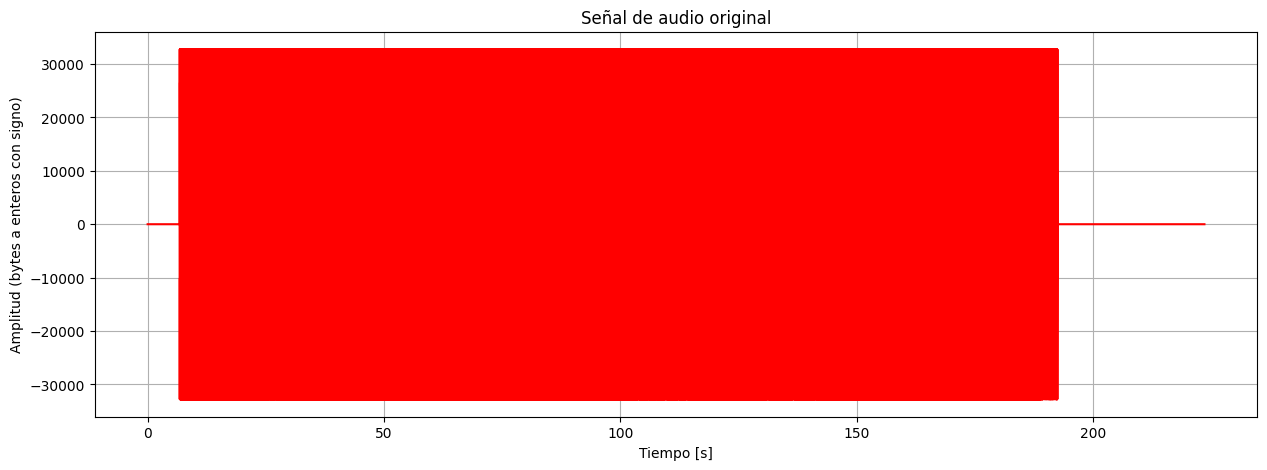

Canales: 1
Bits por muestra: 16
Frecuencia de muestreo: 50000 Hz
Duración: 223.49 segundos
La cantidad de meustras en la señal modulada debe ser igual que en el transmisor: 11174400


In [ ]:
# Importamos el archivo con la señal modulada 
ruta = "Senial_OOK_1000.wav"
Senial_OOK,t_Senial_OOK = Audio_Grafica(ruta)
canales,bits,fs,muestras,duracion=Audio_Caracteristicas(ruta)
print("La cantidad de meustras en la señal modulada debe ser igual que en el transmisor:",muestras)

# Demodulacion
En la practica demodulariamos con un dectector de envolvente, que consta de rectificar la señal y filtrarla 

Se tratara de realizar lo mismo por software 

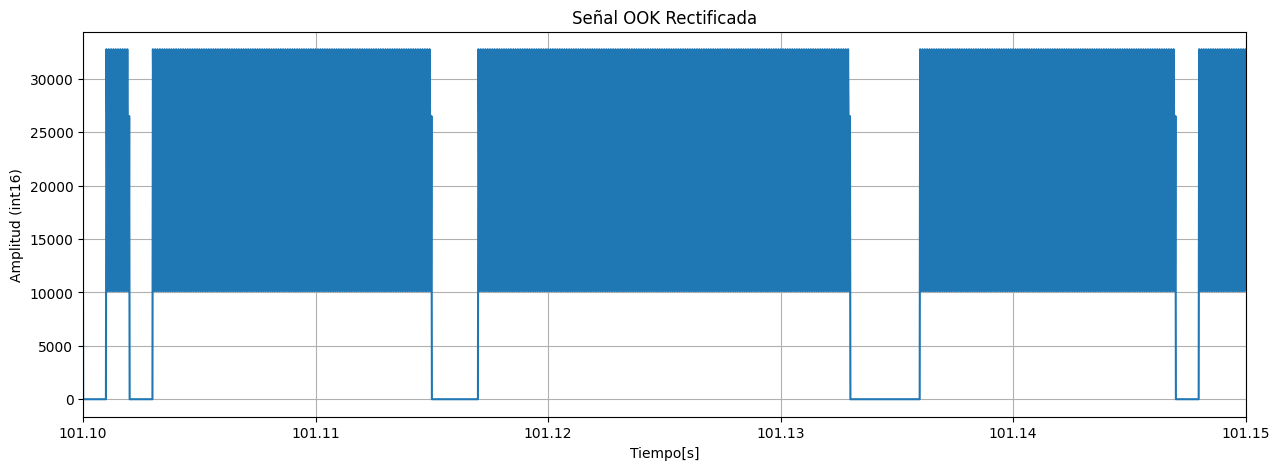

In [11]:
# rectificamos la señal
Senial_OOK_Rectificada = np.abs(Senial_OOK)
#Graficamos la señal rectificada 
plt.figure(figsize=(15,5))
plt.plot(t_Senial_OOK,Senial_OOK_Rectificada)
plt.title("Señal OOK Rectificada")
plt.xlabel("Tiempo[s]")
plt.ylabel("Amplitud (int16)")
plt.grid(True)
plt.xlim(101.1,101.15)
plt.show()

In [6]:
print("Cantidad de elementos en la señal rectificada:",len(Senial_OOK_Rectificada))

Cantidad de elementos en la señal rectificada: 11174400


C:\Users\MI PC\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


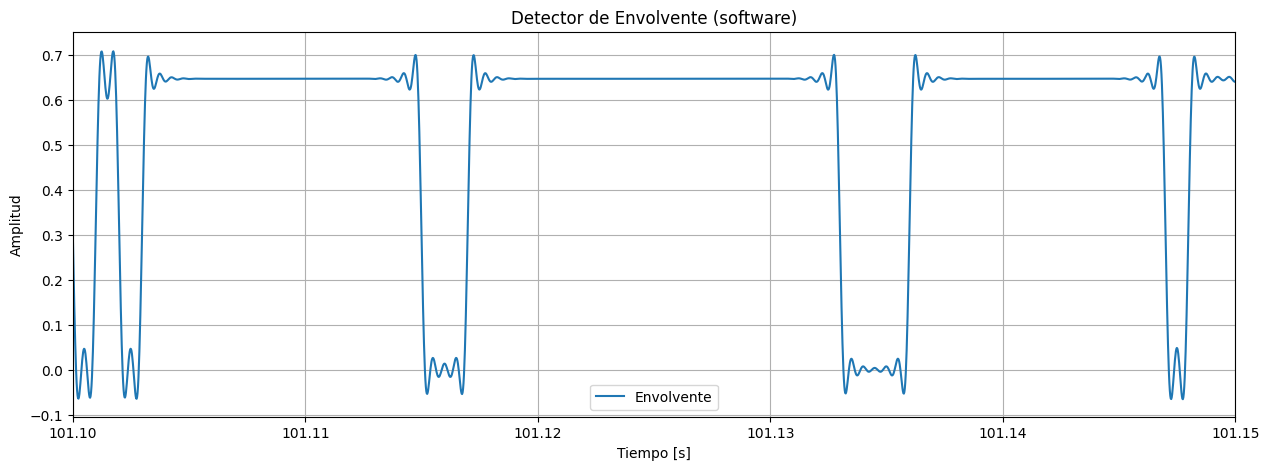

In [44]:

# normalizamos 
# convertimos en numeros de punto flotante (signo,exponente,mantisa)
Senial_OOK_Rectificada = Senial_OOK_Rectificada.astype(np.float16)
# normalizamos la señal dividiendo en el numero maximo del arreglo 
Senial_OOK_Rectificada /= np.max(Senial_OOK_Rectificada)
#filtramos (FPB)
fs = 50000 #[Hz] frecuencia de muestreo de la señal en el transmisor 
fc_audio = 2000 # banda de guarda 
# filtro del tipo Butterworth de orden 8 y del tipo pasa-bajo 
b,a = butter(N=8,Wn=fc_audio/(fs/2),btype='low')
envolvente = filtfilt(b,a,Senial_OOK_Rectificada)

# Graficamos
t = np.arange(len(Senial_OOK)) / fs

plt.figure(figsize=(15,5))
plt.plot(t, envolvente, label='Envolvente')
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.title("Detector de Envolvente (software)")
plt.xlim(101.1,101.15)
plt.legend()
plt.grid(True)
plt.show()


In [45]:
print("Cantidad de elementos en la envolvente:",len(envolvente))

Cantidad de elementos en la envolvente: 11174400


In [46]:
# Determinamos el valor umbral del comparador
umbral = np.mean(envolvente)
print("El valor medio de la envolvente es: ",umbral)

El valor medio de la envolvente es:  0.25893173636417927


C:\Users\MI PC\AppData\Local\Temp\ipykernel_876\2893046184.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\MI PC\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


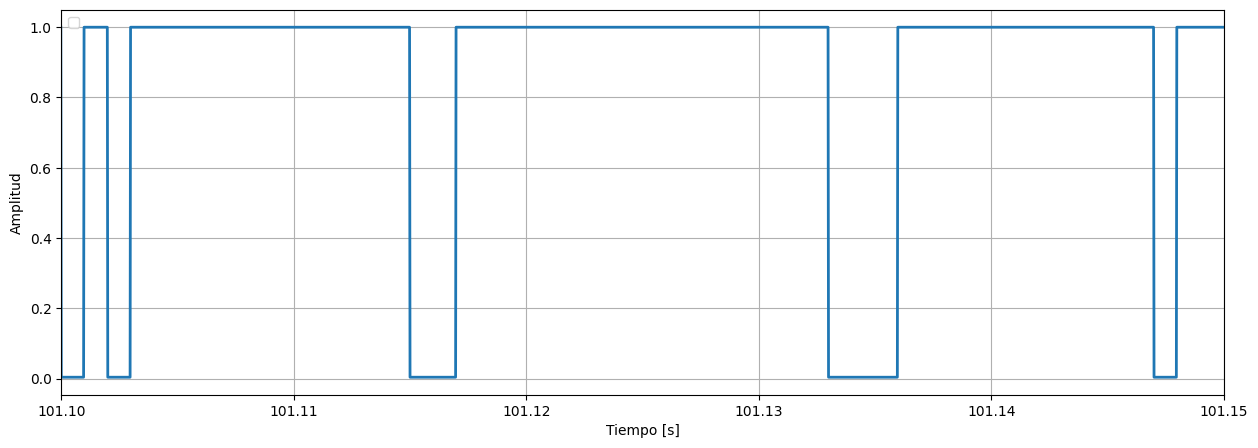

Duracion de Señal reconstruida  223.488


In [ ]:
# comparador
senial_reconstruida = (envolvente > umbral).astype(np.uint8)  
senal_digital_audio = (senial_reconstruida * 2 - 1) * 255  
senal_digital_audio = senal_digital_audio.astype(np.int16)

# Graficamos
t_reconstruida = np.arange(len(senal_digital_audio)) / fs
plt.figure(figsize=(15,5))
plt.plot(t_reconstruida, senal_digital_audio/255, linewidth=2)
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.xlim(101.1,101.15)
plt.legend()
plt.grid(True)
plt.show()
print("Duracion de Señal reconstruida ",len(senal_digital_audio)/50e3)


In [10]:
print("Cantidad de elementos en la señal reconstruida:",len(senial_reconstruida))

Cantidad de elementos en la señal reconstruida: 11174400


In [ ]:
# Volvemos al arreglo original de bits

#Cada x muestras determinamos si se trata de un "1" o "0" segun cuantas muestras por bits tengamos
init_sample = 25 #x
samples_per_bit = 50 #cantidad de muestras por bit
cant_bits = len(senial_reconstruida)// samples_per_bit # cantidad total de bits
print("Cantidad de bits del arreglo: ",cant_bits)

# Reconstruimos el arreglo de bits original 

# Gneramos un arreglo de "0" con el ancho necesario
bits_reshaped = np.zeros(cant_bits,dtype=int)
#recorremos el arreglo original y extraemos el valor de cada bit y lo agregamos en otro arreglo
for i in range(cant_bits):
    sample = i * samples_per_bit + init_sample
    bits_reshaped[i] = senial_reconstruida[sample]
# vemos si el arreglo resultante tiene igual ancho que el que se utilizo en el transmisor 
print("El ancho del arreglo reconstruido es: ",len(bits_reshaped))

Cantidad de bits del arreglo:  223488
El ancho del arreglo reconstruido es:  223488


In [38]:
#Convertimos el arreglo en un arreglo de listas de 16 elementos correspondientes a los 16 bits por muestra
senial_reshape = bits_reshaped.reshape((13968,16))
print("Cantidad de elementos en el arreglo, debe corresponderse con la cantidad de muestras de la señal original: ",len(senial_reshape))


Cantidad de elementos en el arreglo, debe corresponderse con la cantidad de muestras de la señal original:  13968


In [ ]:
# indicamos que el msb es el bit de signo
bin_weights = 1 << np.arange(15,-1,-1)
#Convertimos a enteros sin signo primero 
int_unsigned = senial_reshape.dot(bin_weights)
# Convertimos a enteros con signo 
senial_int_signed = int_unsigned.astype(np.int16) 
print("La cantidad de elementos del arreglo final es: ",len(senial_int_signed))

La cantidad de elementos del arreglo final es:  13968


In [ ]:
# Reconstruimos el eje de tiempos para la fs de 3000 Hz 
fs_original=3000 #[Hz] frecuencia del re-muestreo
Rb=1000 #[bps]
duracion_final = duracion/fs*Rb #[s]
t_audio_demodulada = np.linspace(0,duracion_final,num=(len(senial_int_signed)))

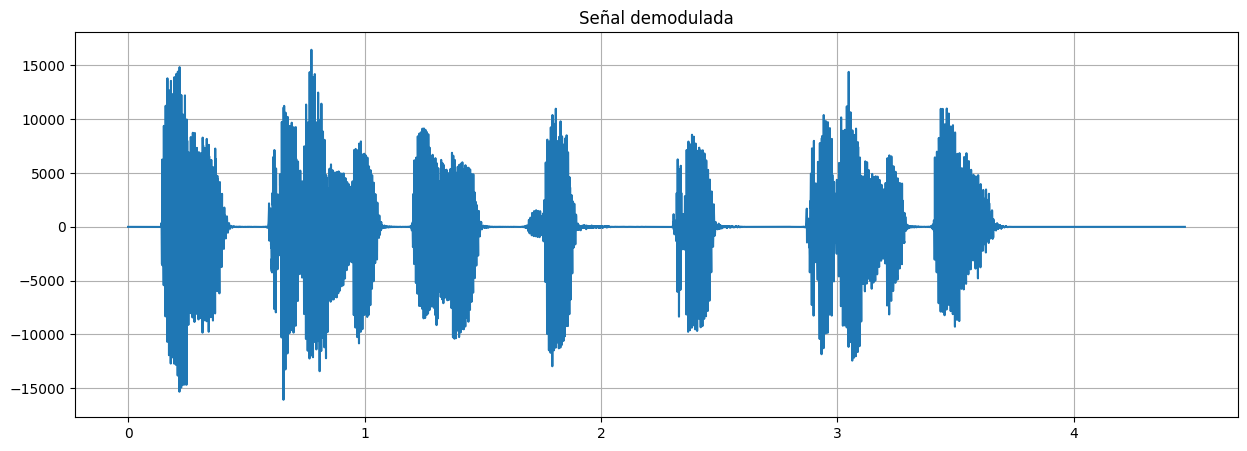

In [42]:
# Graficamos la señal de audio recuperada en funcion del tiempo
plt.figure(figsize=(15,5))
plt.plot(t_audio_demodulada,senial_int_signed)
plt.grid(True)
plt.title("Señal demodulada")
plt.show()

# Archivo de la señal de audio demodulada

In [43]:
wavfile.write('Senial_Demodulada.wav',fs_original,senial_int_signed)